# Raspberry price analysis in the spanish market

Market Data Source: 

    Junta de Andalucía (warehouse output prices paid to farmers)

    http://www.juntadeandalucia.es/agriculturaypesca/observatorio/servlet/FrontController?action=Static&subsector=19&url=subsector.jsp

## Import and cleanance

In [41]:
import pandas as pd
import datetime
pd.set_option('display.max_columns',None) ## Display all columns in pandas dataframe  
pd.set_option('display.max_rows',None) ## Display all rows in pandas dataframe 

sheet_name = 'Observatorio de Precios'
rows_skip_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
rows_skip_14 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
rows_skip_15 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
cols = [0,1]
file_names_year = [  
                    ['Data/ArandanoPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','Blueberry',0,25],\
                    ['Data/FrambuesaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','Raspberry',35,25],\
                    ['Data/FresaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','Strawberry',48,22]\
                  ]

price = pd.DataFrame()
price = pd.read_excel(file_names_year[0][0]\
                               ,sheet_name = file_names_year[0][1]\
                               ,header = 6\
                               ,skiprows = file_names_year[0][2]\
                               ,usecols = file_names_year[0][3]\
                               ,parse_dates=[0])
price.columns = ['Week',file_names_year[0][4]]
price['Crop'] = file_names_year[0][5]
price[['Week_No','Year']] = price.Week.str.split(pat='-',expand=True)
price['Week_No'] = price['Week_No'].astype('int32')
price['Year'] = price['Year'].astype('int32')
price['Week_Campaign'] = price['Week_No'].apply(lambda x: (x - file_names_year[0][6] + 53) % 53 )
price['Week_Campaign'] = price['Week_Campaign'].astype('int32')
price['Year_Campaign'] = price['Week_No'].apply(lambda x : 0 if 0 == file_names_year[0][6] else 0 if x < file_names_year[0][6] else 1)
price['Year_Campaign'] = price['Year_Campaign'].astype('int32')

for i in range(1,len(file_names_year)):
    price_excel=pd.read_excel(file_names_year[i][0]\
                               ,sheet_name=file_names_year[i][1]\
                               ,header=6\
                               ,skiprows=file_names_year[i][2]\
                               ,usecols=file_names_year[i][3]\
                               ,parse_dates=[0])
    price_excel.columns = ['Week',file_names_year[i][4]]
    price_excel[['Week_No','Year']] = price_excel.Week.str.split(pat='-',expand=True)
    price_excel['Week_No'] = price_excel['Week_No'].astype('int32')
    price_excel['Year'] = price_excel['Year'].astype('int32')
    price_excel.drop_duplicates(inplace=True)
    price_excel['Crop'] = file_names_year[i][5]
    price_excel['Week_Campaign'] = price_excel['Week_No'].apply(lambda x: (x - file_names_year[i][6] + 53) % 53 )
    price_excel['Week_Campaign'] = price_excel['Week_Campaign'].astype('int32')
    price_excel['Year_Campaign'] = price_excel['Week_No'].apply(lambda x : 0 if 0 == file_names_year[i][6] else 0 if x < file_names_year[i][6] else 1)
    price_excel['Year_Campaign'] = price_excel['Year_Campaign'].astype('int32')
    price = price.append(price_excel)
        
price['Year_Campaign'] = price['Year_Campaign'] + price['Year']
price['Date_Ref']=price['Week'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%V-%G-%u') )
price.drop(range(0,price.PriceProducer.notna().idxmax()),inplace=True)
price = price [['Crop',\
                'PriceProducer',\
                'Week',\
                'Week_No',\
                'Year',\
                'Date_Ref',\
                'Week_Campaign',\
                'Year_Campaign']]
price.set_index('Date_Ref',inplace=True)

/home/matozqui/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


## Checks

In [42]:
price.columns

Index(['Crop', 'PriceProducer', 'Week', 'Week_No', 'Year', 'Week_Campaign',
       'Year_Campaign'],
      dtype='object')

In [43]:
price.tail()

,Crop,PriceProducer,Week,Week_No,Year,Week_Campaign,Year_Campaign
Date_Ref,,,,,,,
2020-03-16,Strawberry,0.96,12-2020,12,2020,17,2020
2020-03-23,Strawberry,0.80,13-2020,13,2020,18,2020
2020-03-30,Strawberry,0.82,14-2020,14,2020,19,2020
2020-04-06,Strawberry,0.78,15-2020,15,2020,20,2020
2020-04-13,Strawberry,NaN,16-2020,16,2020,21,2020


In [44]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679 entries, 2015-12-21 to 2020-04-13
Data columns (total 7 columns):
Crop             679 non-null object
PriceProducer    419 non-null float64
Week             679 non-null object
Week_No          679 non-null int32
Year             679 non-null int32
Week_Campaign    679 non-null int32
Year_Campaign    679 non-null int32
dtypes: float64(1), int32(4), object(2)
memory usage: 31.8+ KB


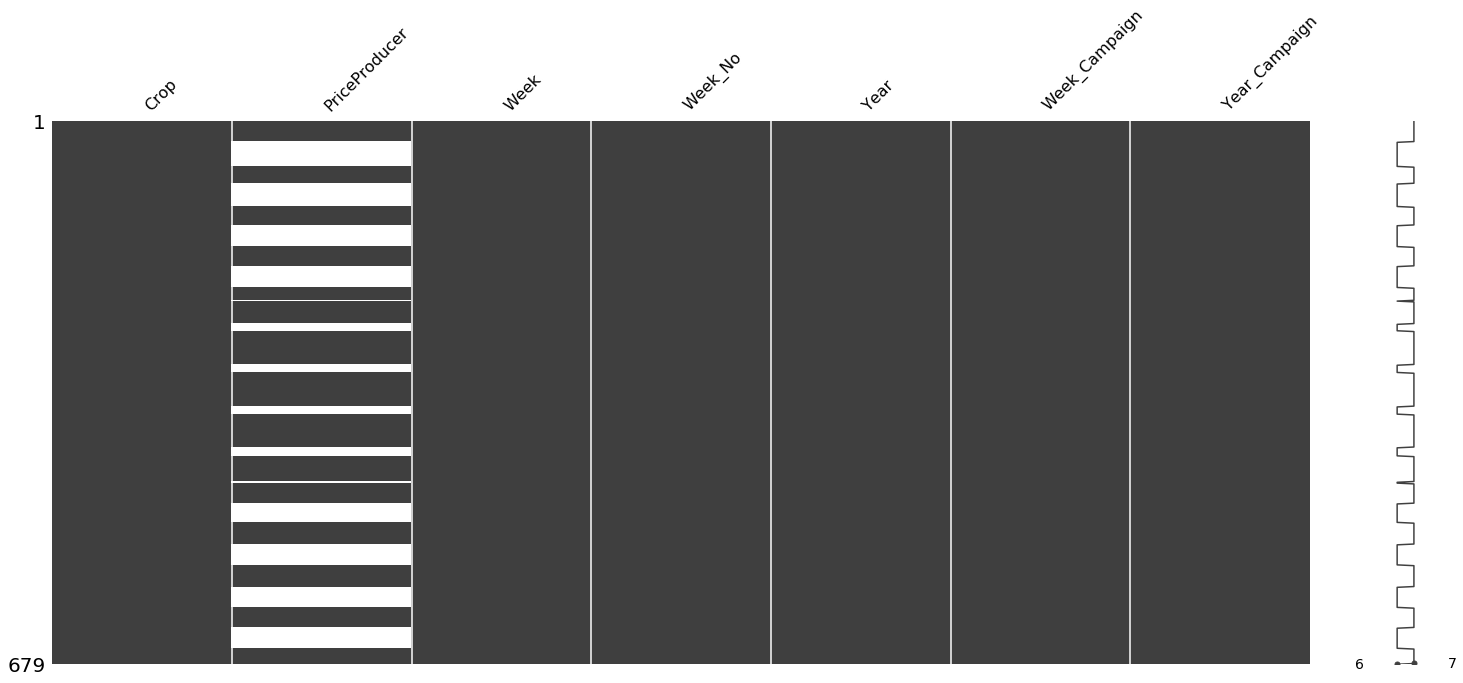

In [45]:
import missingno as msno
msno.matrix(price)

In [46]:
import pandas as pd
price.isnull().sum()

Crop               0
PriceProducer    260
Week               0
Week_No            0
Year               0
Week_Campaign      0
Year_Campaign      0
dtype: int64

In [47]:
price['Week_No'][(price['PriceProducer'].isna()) & (price['Crop']=='Raspberry')].value_counts().reset_index().sort_values(by='index')

,index,Week_No
12,16,1
11,17,1
10,25,1
9,26,3
8,27,4
7,28,4
6,29,4
5,30,4
4,31,4
3,32,4


## Plotting

In [48]:
y = price[price['Crop']=='Raspberry']['PriceProducer'].dropna()

In [49]:
y.shape

(185,)

In [50]:
y

Date_Ref
2015-12-21    5.646639
2015-12-28    4.640552
2016-01-04    3.538821
2016-01-11    4.518137
2016-01-18    5.108314
2016-01-25    4.286356
2016-02-01    4.831854
2016-02-08    5.063393
2016-02-15    5.477878
2016-02-22    6.484883
2016-02-29    6.868696
2016-03-07    8.102199
2016-03-14    7.562989
2016-03-21    7.020303
2016-03-28    5.768558
2016-04-04    5.218123
2016-04-11    4.773811
2016-04-18    4.596339
2016-04-25    5.308883
2016-05-02    5.375187
2016-05-09    7.563390
2016-05-16    7.529130
2016-05-23    6.232107
2016-05-30    4.963665
2016-06-06    3.913814
2016-06-13    3.573406
2016-06-20    3.449375
2016-06-27    3.152336
2016-09-05    6.935501
2016-09-12    5.950724
2016-09-19    7.563904
2016-09-26    7.500637
2016-10-03    7.443938
2016-10-10    6.995991
2016-10-17    6.266405
2016-10-24    6.837070
2016-10-31    6.921011
2016-11-07    6.958075
2016-11-14    6.721394
2016-11-21    6.265566
2016-11-28    5.428999
2016-12-05    4.052552
2016-12-12    4.706221
20

/home/matozqui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


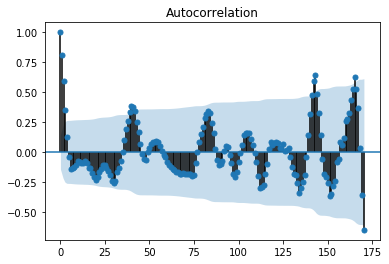

In [51]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
acf(y,unbiased=True)
plot_acf(y,lags=170,unbiased=True);

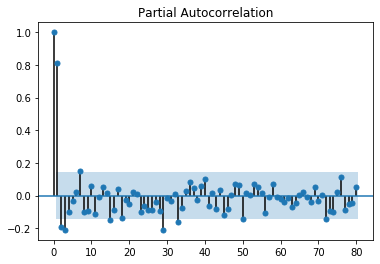

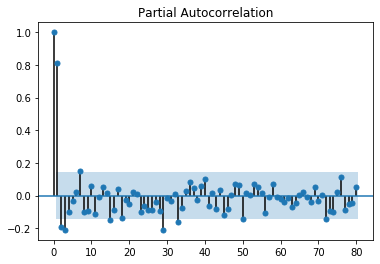

In [52]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y, lags=80)

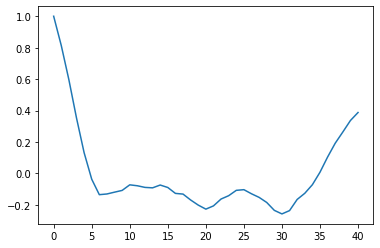

In [53]:
plt.plot(acf(y,unbiased=True))

#### Summary

In [54]:
for i in range(0,len(file_names_year)):
    crop = file_names_year[i][5] 
    summary=(price[(price['Year']>2016) & (price['Crop']==crop)][['Year_Campaign','PriceProducer']].groupby('Year_Campaign')\
                .describe().unstack(1)).to_frame('Value')\
                .reset_index().sort_values('Year_Campaign')
    del summary['level_0']
    summary=summary.pivot_table(index='level_1',columns='Year_Campaign',values='Value',aggfunc='sum')
    summary.reset_index(inplace=True)
    summary.to_excel('./Plots/Summary_'+ crop +'.xlsx')

#### Distribution

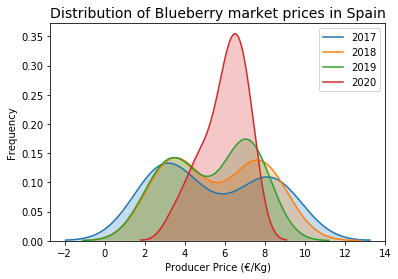

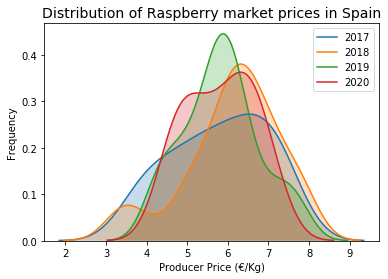

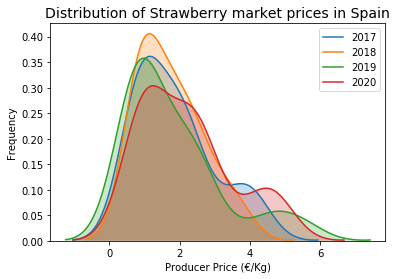

In [55]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

for i in range(0,len(file_names_year)):
    crop = file_names_year[i][5]
    ax = sns.kdeplot(price[(price['Year_Campaign']==2017) & (price['Crop'] == crop)]['PriceProducer'].dropna(),label='2017', shade=True)
    ax = sns.kdeplot(price[(price['Year_Campaign']==2018) & (price['Crop'] == crop)]['PriceProducer'].dropna(),label='2018', shade=True)
    ax = sns.kdeplot(price[(price['Year_Campaign']==2019) & (price['Crop'] == crop)]['PriceProducer'].dropna(),label='2019', shade=True)
    ax = sns.kdeplot(price[(price['Year_Campaign']==2020) & (price['Crop'] == crop)]['PriceProducer'].dropna(),label='2020', shade=True)
    plt.title('Distribution of ' + crop + ' market prices in Spain', fontsize=14)
    plt.xlabel('Producer Price (€/Kg)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.savefig('./Plots/Distribution_' + crop + '.png')
    plt.show()

#### Boxplot

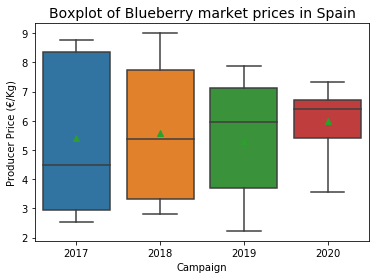

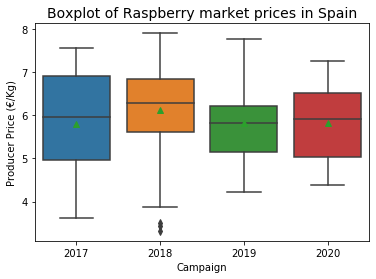

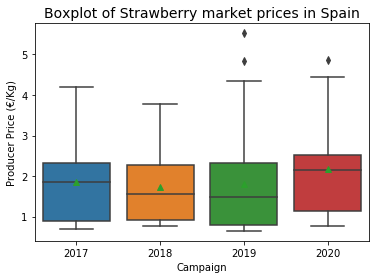

In [56]:
for i in range(0,len(file_names_year)):
    crop = file_names_year[i][5]
    ax = sns.boxplot(x="Year_Campaign", y="PriceProducer", \
                 data=price[(price['Crop']==crop) & (price['Year_Campaign'].isin(['2017','2018','2019','2020']))], showmeans=True)
    plt.title('Boxplot of ' + crop + ' market prices in Spain', fontsize=14)
    plt.xlabel('Campaign', fontsize=10)
    plt.ylabel('Producer Price (€/Kg)', fontsize=10)
    plt.savefig('./Plots/Boxplot_' + crop + '.png')
    plt.show()

#### Evolution

In [65]:
price[price['Crop']=='Blueberry'].tail()

,Crop,PriceProducer,Week,Week_No,Year,Week_Campaign,Year_Campaign
Date_Ref,,,,,,,
2020-03-16,Blueberry,5.16,12-2020,12,2020,12,2020
2020-03-23,Blueberry,4.62,13-2020,13,2020,13,2020
2020-03-30,Blueberry,4.50,14-2020,14,2020,14,2020
2020-04-06,Blueberry,3.56,15-2020,15,2020,15,2020
2020-04-13,Blueberry,NaN,16-2020,16,2020,16,2020


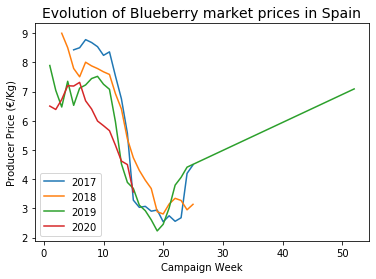

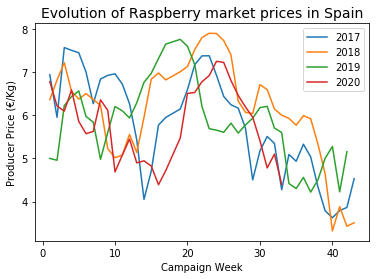

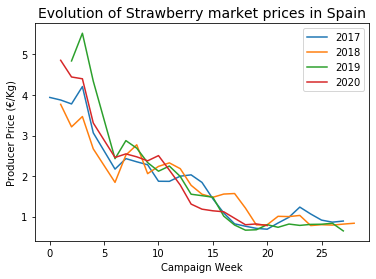

In [67]:
for i in range(0,len(file_names_year)):
    crop = file_names_year[i][5]
    for i in range(2017, 2021):
        data_graph = price[(price['Crop']==crop) & (price['Year_Campaign']==i)][['PriceProducer','Week_Campaign']]
        ax = sns.lineplot(x='Week_Campaign',y='PriceProducer',data=data_graph, label=i)
        
        
    plt.title('Evolution of ' + crop + ' market prices in Spain', fontsize=14)
    plt.xlabel('Campaign Week', fontsize=10)
    plt.ylabel('Producer Price (€/Kg)', fontsize=10)
    plt.savefig('./Plots/Evolution_' + crop + '.png')
    plt.show()

In [59]:
price.groupby(['Crop','Year'])['Week_No'].agg('max')

Crop        Year
Blueberry   2015    53
            2016    52
            2017    52
            2018    52
            2019    52
            2020    16
Raspberry   2015    53
            2016    52
            2017    52
            2018    52
            2019    52
            2020    17
Strawberry  2015    53
            2016    52
            2017    52
            2018    52
            2019    52
            2020    16
Name: Week_No, dtype: int32

In [60]:
price[price['Week_Campaign']==1][['Crop','Year_Campaign','Date_Ref']]

KeyError: "['Date_Ref'] not in index"

In [72]:
price[(price['Crop']=='Blueberry') & (price['Week_No'] == 15)]

,Crop,PriceProducer,Week,Week_No,Year,Week_Campaign,Year_Campaign
Date_Ref,,,,,,,
2016-04-11,Blueberry,4.900854,15-2016,15,2016,15,2016
2017-04-10,Blueberry,3.280690,15-2017,15,2017,15,2017
2018-04-09,Blueberry,4.732598,15-2018,15,2018,15,2018
2019-04-08,Blueberry,3.682053,15-2019,15,2019,15,2019
2020-04-06,Blueberry,3.560000,15-2020,15,2020,15,2020


In [73]:
price[(price['Crop']=='Strawberry') & (price['Week_No'] == 15)]

,Crop,PriceProducer,Week,Week_No,Year,Week_Campaign,Year_Campaign
Date_Ref,,,,,,,
2016-04-11,Strawberry,0.647488,15-2016,15,2016,20,2016
2017-04-10,Strawberry,0.689727,15-2017,15,2017,20,2017
2018-04-09,Strawberry,0.800291,15-2018,15,2018,20,2018
2019-04-08,Strawberry,0.801632,15-2019,15,2019,20,2019
2020-04-06,Strawberry,0.780000,15-2020,15,2020,20,2020


In [70]:
price[(price['Crop']=='Raspberry') & (price['Week_No'] == 15)]

,Crop,PriceProducer,Week,Week_No,Year,Week_Campaign,Year_Campaign
Date_Ref,,,,,,,
2016-04-11,Raspberry,4.773811,15-2016,15,2016,33,2016
2017-04-10,Raspberry,4.274687,15-2017,15,2017,33,2017
2018-04-09,Raspberry,5.997775,15-2018,15,2018,33,2018
2019-04-08,Raspberry,5.598500,15-2019,15,2019,33,2019
2020-04-06,Raspberry,4.400000,15-2020,15,2020,33,2020
